# Домашнее задание 2. Классификация изображений.

In [1]:
# !pip install wandb
# !pip3 install pytorch_lightning torchmetrics

In [3]:
import albumentations as albumentations

# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()
wandb.finish()

wandb: Currently logged in as: dmitysh. Use `wandb login --relogin` to force relogin


In [4]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy as accuracy_metric
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need

In [5]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [6]:
# !wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [6]:
# https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
train_dataset = ImageFolder('dataset/train', transform=transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=256,
                              shuffle=True,
                              num_workers=4)


def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


print('Mean, std')
get_mean_and_std(train_dataloader)

Mean, std


(tensor([0.4802, 0.4481, 0.3975]), tensor([0.2764, 0.2689, 0.2816]))

In [7]:
from torchvision.transforms import InterpolationMode

train_transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(35, interpolation=InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2764, 0.2689, 0.2816)),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2764, 0.2689, 0.2816)),
    ]
)

train_dataset = ImageFolder('dataset/train',
                            transform=train_transform)
val_dataset = ImageFolder('dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=256,
                              shuffle=True,
                              num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=256,
                            shuffle=False,
                            num_workers=4)

In [8]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size: torch.Size([3, 64, 64])


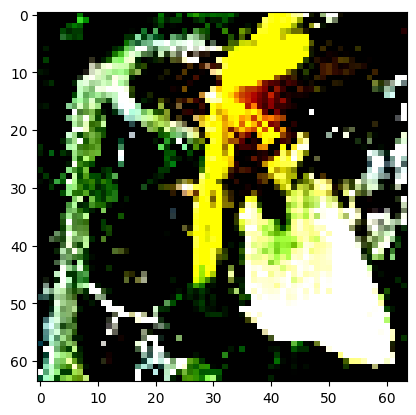

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


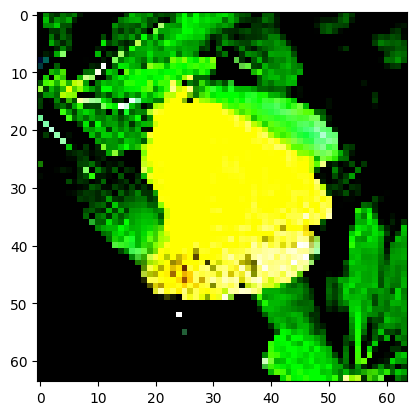

In [9]:
for batch in val_dataloader:
    images, class_nums = batch
    break
plt.imshow(images[5].permute(1, 2, 0))
print('Size:', images[5].shape)
plt.show()
plt.imshow(images[19].permute(1, 2, 0))
plt.show()

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

## Обучение импортированной модели

In [10]:
seed_everything(123456)


class ImportedModelTrainer(pl.LightningModule):
    def __init__(self, model, pretrained, lr=1e-3):
        super().__init__()
        self.model = model
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False

        self.learning_rate = lr
        self.model.fc = nn.Linear(512, 200)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss = nn.CrossEntropyLoss()
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.7)

    def forward(self, x):
        x = self.model(x)

        return x

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        self.log("step_size", self.scheduler.get_last_lr()[0], prog_bar=True)

        # step every N epochs
        if self.trainer.is_last_batch:
            if (self.trainer.current_epoch + 1) % 4 == 0:
                self.scheduler.step()

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy_metric(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [11]:
from torchvision.models import resnet34

device = 'cuda:0'

model = resnet34().to(device)
module = ImportedModelTrainer(model=model, pretrained=False, lr=1e-3)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
wandb.finish()
wandb.init(project="ida-hw2", entity="dmitysh")
wandb_logger = WandbLogger(log_model='all')
trainer = pl.Trainer(accelerator="gpu", devices=-1, max_epochs=18, logger=wandb_logger)

C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(module, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 21.4 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.549    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=18` reached.


In [14]:
# torch.save(model.state_dict(), 'saved_models/max')

In [ ]:
# model1 = resnet34(num_classes=200)
# model1.load_state_dict(torch.load('saved_models/max'))

### Валидация результатов задания

In [18]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            out = model(images)
            preds = torch.argmax(out, dim=-1)
            acc_batch = accuracy_metric(preds.long(), labels.long())
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy.cpu()

In [15]:
accuracy = evaluate_task(model, val_dataloader)
print(f'Accuracy: {accuracy}')
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 40/40 [00:07<00:00,  5.09it/s]

Accuracy: 0.41064453125
Оценка за это задание составит 9.33 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

In [7]:
from torchvision.models import vit_l_32, ViT_L_32_Weights

weights = ViT_L_32_Weights.DEFAULT
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
from torchvision.transforms import InterpolationMode

seed_everything(123456)

# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30, interpolation=InterpolationMode.BILINEAR),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = ImageFolder('dataset/train',
                            transform=train_transform)
val_dataset = ImageFolder('dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=256,
                              shuffle=True,
                              num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=256,
                            shuffle=False,
                            num_workers=4)

In [9]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size: torch.Size([3, 224, 224])


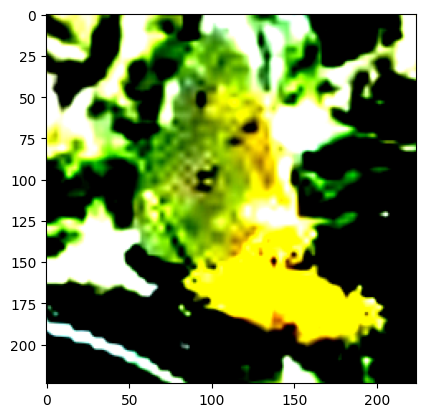

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


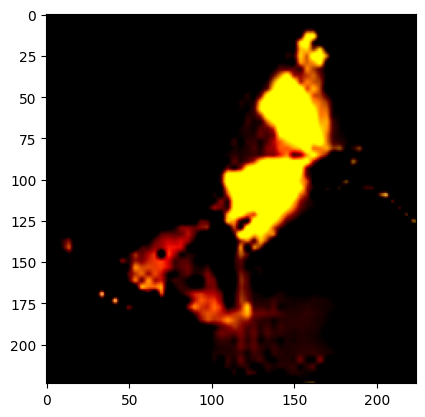

In [10]:
for batch in val_dataloader:
    images, class_nums = batch
    break
plt.imshow(images[1].permute(1, 2, 0))
print('Size:', images[5].shape)
plt.show()
plt.imshow(images[2].permute(1, 2, 0))
plt.show()

### Тренировочный класс lightning

In [11]:
seed_everything(123456)


class SecondImportedModelTrainer(pl.LightningModule):
    def __init__(self, model, pretrained, lr=1e-3, reduce_epochs=4):
        super().__init__()
        self.model = model
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False

        self.learning_rate = lr
        self.reduce_epochs = reduce_epochs

        self.model.heads.head = nn.Linear(1024, 200)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.loss = nn.CrossEntropyLoss()
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.8)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        self.log("step_size", self.scheduler.get_last_lr()[0], prog_bar=True)

        # step every N epochs
        if self.trainer.is_last_batch:
            if (self.trainer.current_epoch + 1) % self.reduce_epochs == 0:
                self.scheduler.step()

        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy_metric(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [12]:
device = 'cuda:0'

model = vit_l_32(weights=ViT_L_32_Weights.DEFAULT).to(device)
module = SecondImportedModelTrainer(model=model, pretrained=True, lr=1e-3, reduce_epochs=2)
model

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (

In [13]:
wandb.finish()
wandb.init(project="ida-hw2-part2", entity="dmitysh")
wandb_logger = WandbLogger(log_model='all')
trainer = pl.Trainer(accelerator="gpu", devices=-1, max_epochs=1, logger=wandb_logger)

C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(module, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | VisionTransformer | 305 M 
1 | loss  | CrossEntropyLoss  | 0     
--------------------------------------------
205 K     Trainable params
305 M     Non-trainable params
305 M     Total params
1,222.862 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [15]:
# torch.save(model.state_dict(), 'saved_models/max-2')

In [16]:
# model1 = vit_l_32(num_classes=200)
# model1.load_state_dict(torch.load('saved_models/max-2'))

### Валидация результатов задания

In [19]:
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 40/40 [01:49<00:00,  2.75s/it]

Оценка за это задание составит 10.00 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

Для первой части я пробовал сначала 101 и 152 resNet'ы, причем с аугментацией с семинара, а потом вообще без нее. Модель переобучалсь. Я сильно увеличил трансформации в аугмегнтации, но модель перестала учиться. Потом я стал собственноручно подбирать агументации шаг за шагом. Иногда кстати менял шаг обучения и число эпох для его уменьшения. Потом попробовал 18 resNet, на котором получил уже хорошее качество. Но потом сделал аугментацию пожестче и выбрал resNet34, на котором и получил финальное качество.
Для второй части я пробовал всевозможные resNet'ы, потом нашел наконец как нужно ресайзить и кропить картинки, чтобы они соответствовали тем, на которых сети учились. Потом игрался с аугментацией и качество было очень не очень, потом я долго и нудно пытался обучить 152 resNet, но все равно было не очень. Где-то даже пробовал efficientNet. Но потом нашел Vit, которые сразу помогли решить задачу на максимум))))

И под конец ссылочки:
https://wandb.ai/dmitysh/ida-hw2?workspace=user-dmitysh - часть 1
https://wandb.ai/dmitysh/ida-hw2-part2?workspace=user-dmitysh - часть 2